## Enlaces de interés:  
Un poquito de keras con NLP y tweets  
https://medium.com/geekculture/nlp-with-tensorflow-keras-explanation-and-tutorial-cae3554b1290  
Dataset de kaggle que sigo  
https://www.kaggle.com/datasets/gargmanas/sentimental-analysis-for-tweets  
Otro poco de keras  
https://www.activestate.com/resources/quick-reads/how-to-create-a-neural-network-in-python-with-and-without-keras/  
Deploy a nn
https://www.flir.com/discover/iis/machine-vision/5-steps-for-building-and-deploying-a-deep-learning-neural-networks/

 # Imports and Dataset loading

In [1]:
import csv
import pandas as pd
import numpy as np

from wordcloud import WordCloud
from PIL import Image

from scipy import stats
import matplotlib.pyplot as plt
import random

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
df = pd.read_csv('resources/sentiment_tweets3.csv')
df

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,802312,dont mistake a bad day with depression! everyo...,1


In [3]:
df.rename(columns = {'Index':'index', 'message to examine':'message', 'label (depression result)':'is_depressed'}, inplace = True)

In [4]:
df.head()

,index,message,is_depressed
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


# Dataset Analysis and Feature Engineering

En esta sección vamos a analizar los datos que tenemos, intentando extraer de ellos toda la información posible, tanto aquella que pueda sernos útiles a nosotros como a la red neuronal.

## First Look

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         10314 non-null  int64 
 1   message       10314 non-null  object
 2   is_depressed  10314 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 241.9+ KB


Vamos a comenzar por analizar la distribución de tweets en cuanto a si son de gente deprimida o no

In [6]:
df['is_depressed'].value_counts()

0    8000
1    2314
Name: is_depressed, dtype: int64

C:\Users\rariv\AppData\Local\Temp\ipykernel_26676\923297490.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['is_depressed']).sum().plot(kind='pie', y='index',autopct='%1.0f%%')


<AxesSubplot: ylabel='index'>

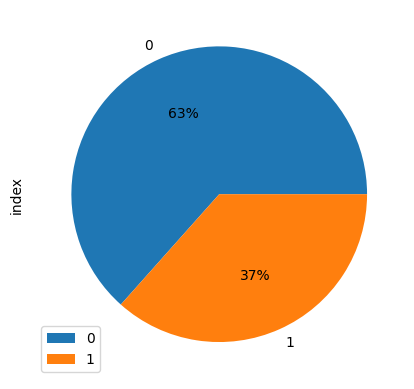

In [7]:

#histogram = df.plot.pie(y=2)
df.groupby(['is_depressed']).sum().plot(kind='pie', y='index',autopct='%1.0f%%')

Aunque el análisis estadístico no nos vaya a aportar mucho podría permitirnos detectar si hay tweets etiquetados fuera del rango esperado [0,1]

In [8]:
df['is_depressed'].describe()

count    10314.000000
mean         0.224355
std          0.417177
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_depressed, dtype: float64

## Feature Engineering

Como el dataset nos ofrece poco a simple vista, vamos a intentar sacar algo de información extra de la columna que más información aporta: el twit en sí. Podemos medir las longitudes en caracteres, en palabras, saber si hay menciones o hashtags en el twit... Como del twit únicamente tenemos el texto, no podemos saber las visualizaciones o interacciones que han tenido, esto es: 'me gusta', 'retweeets' etc.

Puede ser interesante sacar la longitud de los tweets en caracteres.

In [9]:
def calc_char_count(message_column):
    return message_column.apply(len)

Igualmente, puede ser interesante saber qué longitud en palabras tienen los tweets.

In [10]:
def calc_word_count(message_column):
    return message_column.apply(lambda x: len(x.split(' ')))

Por otra parte, en twitter tenemos hashtags en los twits, que pueden llegar a aportar información

In [11]:
def calc_hashtag_count(message_column):
    return message_column.apply(lambda x: len([word for word in x.split(' ') if word.startswith('#')]))

Las menciones también nos pueden aportar algo de información debido a que suelen implicar interacciones sociales directas

In [12]:
def calc_mention_count(message_column):
    return message_column.apply(lambda x: len([word for word in x.split(' ') if word.startswith('@')]))

Vamos a unir todas las funciones en una que podamos aplicar con facilidad, dado que más adelante filtraremos cosas del dataframe y será necesario actualizar las columnas que hemos generado

In [13]:
def update_features(message_column):
    return calc_char_count(message_column), calc_word_count(message_column), calc_hashtag_count(message_column), calc_mention_count(message_column)

df['char_count'], df['word_count'], df['hashtag_count'], df['mention_count'] = update_features(df['message'])

## Analyzing extracted features

Vamos a analizar algunas de las columnas del dataset para ver algo de información estadística sobre ellas

### char_length

Analizar la longitud en caracteres nos puede ayudar a detectar tweets con un formato no válido (más de 280 caracteres actualmente). Elon Musk (actual CEO de twitter) ha afirmado que el límite será ampliado en un futuro así que no veo la necesidad de limpiar el dataset de estos valores actualmente, pero puede ser interesante saber si existen o no.

In [14]:
df['char_count'].describe()

count    10314.000000
mean        92.616153
std         64.670905
min          1.000000
25%         48.000000
50%         78.000000
75%        119.000000
max        874.000000
Name: char_count, dtype: float64

(array([4.310e+02, 1.797e+03, 1.958e+03, 1.700e+03, 1.364e+03, 1.155e+03,
        8.790e+02, 1.640e+02, 1.250e+02, 1.110e+02, 9.800e+01, 1.220e+02,
        1.800e+02, 1.070e+02, 5.700e+01, 2.900e+01, 1.100e+01, 5.000e+00,
        1.000e+01, 1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([  1.   ,  22.825,  44.65 ,  66.475,  88.3  , 110.125, 131.95 ,
        153.775, 175.6  , 197.425, 219.25 , 241.075, 262.9  , 284.725,
        306.55 , 328.375, 350.2  , 372.025, 393.85 , 415.675, 437.5  ,
        459.325, 481.15 , 502.975, 524.8  , 546.625, 568.45 , 590.275,
        612.1  , 633.925, 655.75 , 677.575, 699.4  , 721.225, 743.05 ,
        764.875, 786.7  , 808.525, 830.35 , 852.175, 874.   ]),
 <BarContainer object of 40 artists>)

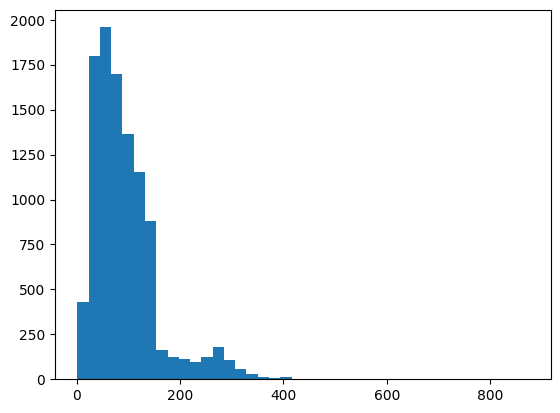

In [15]:
plt.hist(df['char_count'], 40)

### word_count

Analizar la longitud del tweet en palabras nos puede valer para luego decidir qué cantidad de palabras de cada twit queremos pasarle al modelo

In [16]:
df['word_count'].describe()

count    10314.000000
mean        16.066124
std         10.024623
min          1.000000
25%          9.000000
50%         14.000000
75%         21.000000
max         92.000000
Name: word_count, dtype: float64

(array([2.210e+02, 6.910e+02, 9.970e+02, 1.608e+03, 9.360e+02, 8.970e+02,
        8.590e+02, 1.043e+03, 6.230e+02, 5.720e+02, 7.020e+02, 2.930e+02,
        1.700e+02, 9.800e+01, 9.200e+01, 3.800e+01, 5.600e+01, 6.500e+01,
        5.600e+01, 4.800e+01, 6.100e+01, 8.700e+01, 3.900e+01, 2.400e+01,
        1.500e+01, 1.500e+01, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.   ,  3.275,  5.55 ,  7.825, 10.1  , 12.375, 14.65 , 16.925,
        19.2  , 21.475, 23.75 , 26.025, 28.3  , 30.575, 32.85 , 35.125,
        37.4  , 39.675, 41.95 , 44.225, 46.5  , 48.775, 51.05 , 53.325,
        55.6  , 57.875, 60.15 , 62.425, 64.7  , 66.975, 69.25 , 71.525,
        73.8  , 76.075, 78.35 , 80.625, 82.9  , 85.175, 87.45 , 89.725,
        92.   ]),
 <BarContainer object of 40 artists>)

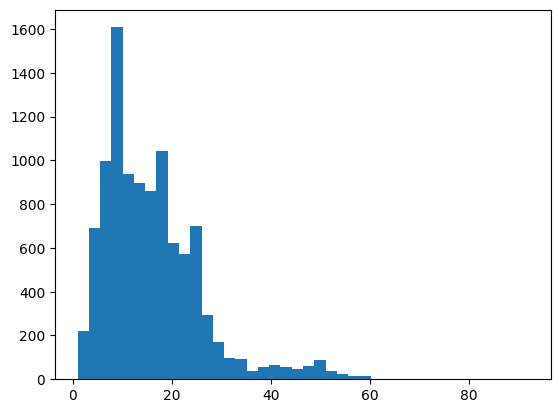

In [17]:
plt.hist(df['word_count'], 40)

### hashtag_count

Analizar la cantidad de hashtags puede ayudarnos a saber si nos van a aportar información útil o es mejor quitarlos

In [18]:
df['hashtag_count'].describe()

count    10314.000000
mean         0.135738
std          0.880968
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         24.000000
Name: hashtag_count, dtype: float64

(array([9.743e+03, 3.440e+02, 0.000e+00, 7.300e+01, 0.000e+00, 4.200e+01,
        3.000e+01, 0.000e+00, 2.300e+01, 0.000e+00, 1.700e+01, 1.700e+01,
        0.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 4.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 5.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  0.6,  1.2,  1.8,  2.4,  3. ,  3.6,  4.2,  4.8,  5.4,  6. ,
         6.6,  7.2,  7.8,  8.4,  9. ,  9.6, 10.2, 10.8, 11.4, 12. , 12.6,
        13.2, 13.8, 14.4, 15. , 15.6, 16.2, 16.8, 17.4, 18. , 18.6, 19.2,
        19.8, 20.4, 21. , 21.6, 22.2, 22.8, 23.4, 24. ]),
 <BarContainer object of 40 artists>)

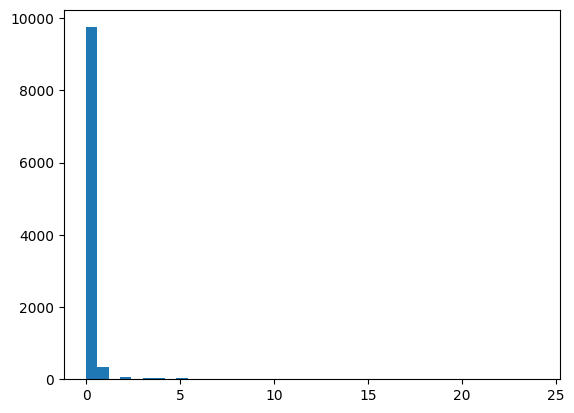

In [19]:
plt.hist(df['hashtag_count'], 40)

### mention_count

In [20]:
df['mention_count'].describe()

count    10314.000000
mean         0.558561
std          0.962656
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         48.000000
Name: mention_count, dtype: float64

(array([9.898e+03, 2.800e+02, 7.700e+01, 2.200e+01, 1.800e+01, 9.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ,
        13.2, 14.4, 15.6, 16.8, 18. , 19.2, 20.4, 21.6, 22.8, 24. , 25.2,
        26.4, 27.6, 28.8, 30. , 31.2, 32.4, 33.6, 34.8, 36. , 37.2, 38.4,
        39.6, 40.8, 42. , 43.2, 44.4, 45.6, 46.8, 48. ]),
 <BarContainer object of 40 artists>)

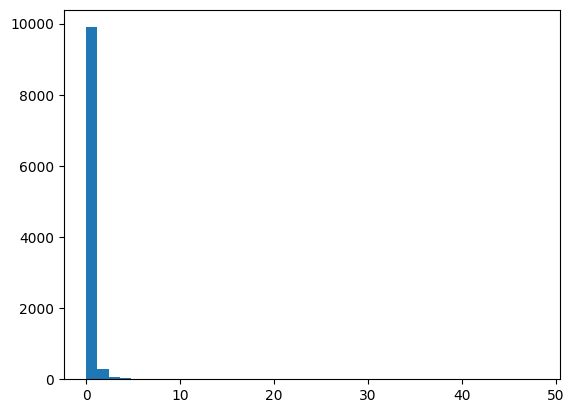

In [21]:
plt.hist(df['mention_count'], 40)

# Preprocessing

## Definiendo funciones de filtrado

Quizá limpiar un poco los twits nos permita extraer información de ellos más fácilmente, hemos visto que los hashtags por ejemplo no aportan mucha información, las stopwords generalmente tampoco son útiles, así que también vamos a quitarlas. Por el momento dejaremos las menciones.

### StopWords

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rariv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
# Función que devuelve un string sin las stopwords que tenga.
def filter_stopwords(tweet):
    return ' '.join(word for word in tweet.split(' ') if word not in set(stopwords.words("english")))

### Hashtags

In [24]:
# Función que devuelve un string sin los hashtags que tenga.
def filter_hashtags(tweet):
    return ' '.join(word for word in tweet.split(' ') if not word.startswith('#'))

### Mentions

In [25]:
# Función que devuelve un string sin las menciones que tenga.
def filter_mentions(tweet):
    return ' '.join(word for word in tweet.split(' ') if not word.startswith('@'))

### URLS

In [26]:
def filter_urls(tweet):
    return ' '.join(word for word in tweet.split(' ') if not (word.startswith('http') or word.startswith('www')))

### Función de filtrado general

In [27]:
def filter_everything(tweet):
    tweet = filter_stopwords(tweet)
    tweet = filter_hashtags(tweet)
    tweet = filter_mentions(tweet)
    tweet = filter_urls(tweet)
    return tweet

## Aplicando los filtros al dataset

In [28]:
df['message'].head()

0    just had a real good moment. i missssssssss hi...
1           is reading manga  http://plurk.com/p/mzp1e
2    @comeagainjen http://twitpic.com/2y2lx - http:...
3    @lapcat Need to send 'em to my accountant tomo...
4        ADD ME ON MYSPACE!!!  myspace.com/LookThunder
Name: message, dtype: object

In [29]:
df_filtered = df
df_filtered['message'] = df['message'].apply(filter_everything)
df_filtered['char_count'], df_filtered['word_count'], df_filtered['hashtag_count'], df_filtered['mention_count'] = update_features(df_filtered['message'])

In [30]:
df_filtered['message'].head()

0                real good moment. missssssssss much, 
1                                       reading manga 
2                                                   - 
3    Need send 'em accountant tomorrow. Oddly, I ev...
4        ADD ME ON MYSPACE!!!  myspace.com/LookThunder
Name: message, dtype: object

## Depressed vs Non-Depressed Visualization: WordCloud

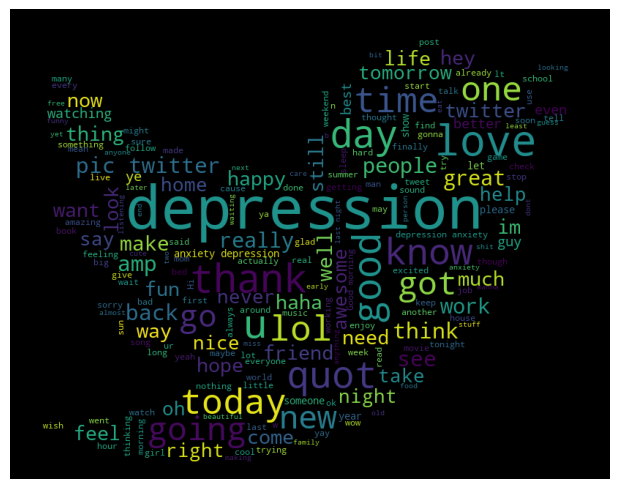

In [31]:
all_strings = df_filtered['message'].sum()
mask = np.array(Image.open('resources/twitter_logo.png'))
word_cloud_all = WordCloud(mask=mask,width=mask.shape[1],
               height=mask.shape[0],background_color="black", max_words=200).generate(all_strings)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(word_cloud_all)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

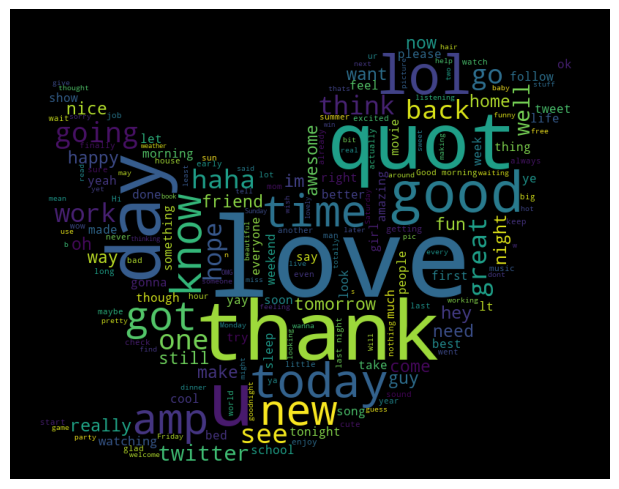

In [32]:
non_depressed = df[df_filtered['is_depressed']==0]
non_depressed_cloud = WordCloud(mask=mask,width=mask.shape[1],
               height=mask.shape[0],background_color="black", max_words=200).generate(non_depressed['message'].sum())
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(non_depressed_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

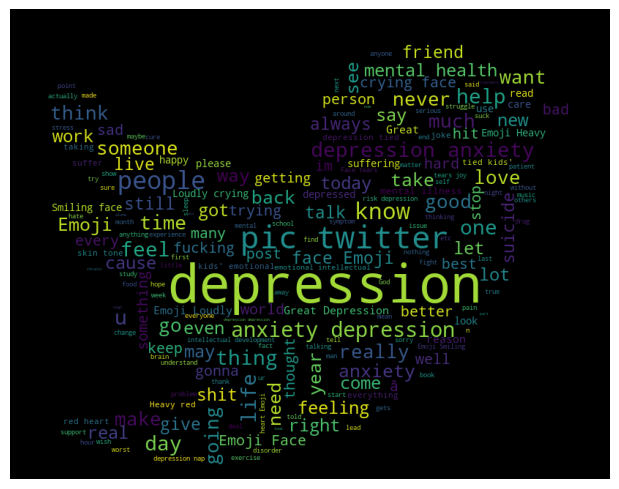

In [33]:
depressed = df[df_filtered['is_depressed']==1]
depressed_cloud = WordCloud(mask=mask,width=mask.shape[1],
               height=mask.shape[0],background_color="black", max_words=200).generate(depressed['message'].sum())
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(depressed_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## Preparing the data for the model

## Tokenization
https://machinelearningknowledge.ai/keras-tokenizer-tutorial-with-examples-for-fit_on_texts-texts_to_sequences-texts_to_matrix-sequences_to_matrix/?utm_content=cmp-true


In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer


tokenizer = Tokenizer(num_words=10000)
#fit tokenizer into data
tokenizer.fit_on_texts(df_filtered['message'])

#convert data to sequences
sequences = tokenizer.texts_to_sequences(df_filtered['message'])

# Print the word index
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 15836


In [139]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences to a fixed length

padded_sequences = pad_sequences(sequences, maxlen=25, padding='post', truncating='post')

In [140]:
print(padded_sequences)

[[ 142    4  627 ...    0    0    0]
 [ 462 6286    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [2664 4146 2128 ...    0    0    0]
 [ 236 1652  129 ...    0    0    0]
 [ 667    0    0 ...    0    0    0]]


## Train/Test Split

## Aprox view of train/test

In [38]:
#here we should split the set in test/dev/test or something similar
# firstly we will do it with just the filtered data to get some insights, then we will do it again with the tokenized and padded data
train, test = train_test_split(df_filtered, test_size=0.2, random_state=42, shuffle=True)

In [141]:
train

,index,message,is_depressed,char_count,word_count,hashtag_count,mention_count
6244,621509,"[1, 26, 1, 721, 1027, 1143, 0, 0, 0, 0, 0, 0, ...",0,26,8,0,0
2124,217911,"[17, 4832, 1480, 1833, 0, 0, 0, 0, 0, 0, 0, 0,...",0,26,5,0,0
3601,364775,"[9186, 3, 436, 20, 9187, 18, 869, 0, 0, 0, 0, ...",0,38,9,0,0
1295,131930,"[124, 1864, 4606, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0,24,4,0,0
8849,800849,"[1, 26, 963, 338, 2, 996, 517, 301, 1785, 526,...",1,179,31,0,0
...,...,...,...,...,...,...,...
5734,573367,"[295, 42, 17, 157, 1045, 0, 0, 0, 0, 0, 0, 0, ...",0,32,6,0,0
5191,518087,"[2622, 5506, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,30,7,0,0
5390,537900,"[1047, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,10,2,0,0
860,88474,"[449, 1852, 4349, 393, 1, 6, 4479, 59, 91, 26,...",0,64,12,0,0


C:\Users\rariv\AppData\Local\Temp\ipykernel_26676\1548909727.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train.groupby(['is_depressed']).sum().plot(kind='pie', y='index',autopct='%1.0f%%')


<AxesSubplot: ylabel='index'>

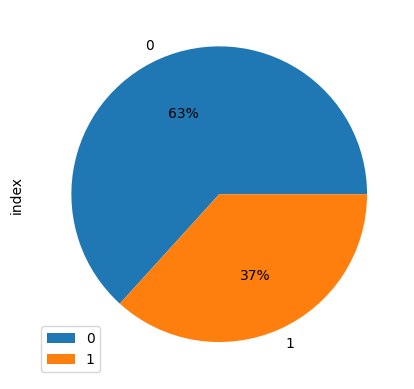

In [40]:
train.groupby(['is_depressed']).sum().plot(kind='pie', y='index',autopct='%1.0f%%')

In [41]:
test

,index,message,is_depressed,char_count,word_count,hashtag_count,mention_count
2458,251196,must Maybe I'll win lottery able afford ;),0,43,9,0,0
5046,504883,"You poor girl, I feel you!",0,27,7,0,0
7872,787069,"I could done same, bag chips, hammer",0,37,8,0,0
9384,801384,After years no-appetite/depression I gained we...,1,159,22,0,0
5254,523640,"By way, Misu, Minni Lady petzz Misu Minni Fin...",0,60,12,0,0
...,...,...,...,...,...,...,...
6138,610890,Making salad house doors open blinds up... I l...,0,50,10,0,0
2956,300453,Loves color morning,0,20,4,0,0
2273,231974,awwwwww realllyy??? *blushin*,0,30,4,0,0
4792,480833,I forgot give hug I left yesterday.. I'm feeli...,0,53,11,0,0


C:\Users\rariv\AppData\Local\Temp\ipykernel_26676\4028934995.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test.groupby(['is_depressed']).sum().plot(kind='pie', y='index',autopct='%1.0f%%')


<AxesSubplot: ylabel='index'>

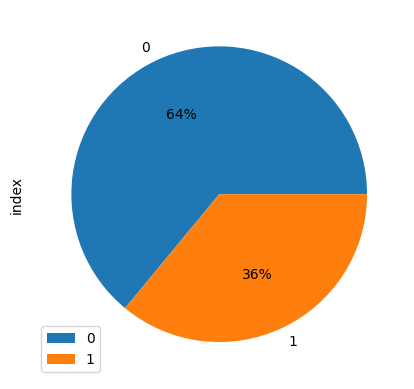

In [42]:
test.groupby(['is_depressed']).sum().plot(kind='pie', y='index',autopct='%1.0f%%')

## Final Processing

After getting some aproximate insights, we will do the same with the processed data

In [125]:
df_processed = df_filtered

df_processed


,index,message,is_depressed,char_count,word_count,hashtag_count,mention_count
0,106,"[142, 4, 627, 6285, 38, 0, 0, 0, 0, 0, 0, 0, 0...",0,37,6,0,0
1,217,"[462, 6286, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0,14,3,0,0
2,220,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,2,2,0,0
3,288,"[53, 547, 2292, 6287, 78, 6288, 1, 89, 2009, 6...",0,101,15,0,0
4,540,"[349, 37, 120, 646, 646, 30, 6290, 0, 0, 0, 0,...",0,45,6,0,0
...,...,...,...,...,...,...,...
10309,802309,"[94, 2, 1746, 459, 120, 3, 123, 2286, 41, 702,...",1,64,11,0,0
10310,802310,"[124, 2, 444, 202, 62, 7, 82, 290, 0, 0, 0, 0,...",1,60,9,0,0
10311,802311,"[2664, 4146, 2128, 586, 912, 2665, 2, 372, 0, ...",1,62,8,0,0
10312,802312,"[236, 1652, 129, 5, 2, 76, 2292, 0, 0, 0, 0, 0...",1,46,7,0,0


In [126]:
df_processed['message']

0        [142, 4, 627, 6285, 38, 0, 0, 0, 0, 0, 0, 0, 0...
1        [462, 6286, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
2        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3        [53, 547, 2292, 6287, 78, 6288, 1, 89, 2009, 6...
4        [349, 37, 120, 646, 646, 30, 6290, 0, 0, 0, 0,...
                               ...                        
10309    [94, 2, 1746, 459, 120, 3, 123, 2286, 41, 702,...
10310    [124, 2, 444, 202, 62, 7, 82, 290, 0, 0, 0, 0,...
10311    [2664, 4146, 2128, 586, 912, 2665, 2, 372, 0, ...
10312    [236, 1652, 129, 5, 2, 76, 2292, 0, 0, 0, 0, 0...
10313    [667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
Name: message, Length: 10314, dtype: object

In [133]:
train, test = train_test_split(df_processed, test_size=0.2, random_state=42, shuffle=True)
X_train,X_test,y_train,y_test=train_test_split(padded_sequences,df_filtered['is_depressed'],test_size=0.2,random_state=42, shuffle=True)

In [134]:
print(X_train)

[[   1   26    1 ...    0    0    0]
 [  17 4832 1480 ...    0    0    0]
 [9186    3  436 ...    0    0    0]
 ...
 [1047    0    0 ...    0    0    0]
 [ 449 1852 4349 ...    0    0    0]
 [ 497   16 1776 ...    0    0    0]]


# Creating the Model

In [45]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000, 16, input_length=25),#tengo que mirar mejor esto
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
     loss='binary_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

In [136]:
model.fit(X_train, y_train)

258/258 [==============================] - 3s 12ms/step - loss: 0.0240 - accuracy: 0.9944


In [138]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

65/65 [==============================] - 1s 3ms/step - loss: 0.0327 - accuracy: 0.9908
test loss, test acc: [0.03272376209497452, 0.9907901287078857]
